<a href="https://colab.research.google.com/github/Mohanbalu/Code/blob/main/PSC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# ============================================================
# BLOCK 1 — INSTALL & IMPORT
# ============================================================

!pip install scikit-fuzzy scikit-learn matplotlib pandas seaborn --quiet

import os, pickle, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

sns.set(style="whitegrid")

ARTIFACT_DIR = "artifacts"
PLOTS_DIR = os.path.join(ARTIFACT_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)


In [ ]:
# ============================================================
# BLOCK 2 — UTILITY FUNCTIONS
# ============================================================

def mf_centroid(universe, mf):
    denom = np.sum(mf)
    if denom == 0:
        return np.mean(universe)
    return float(np.sum(universe * mf) / denom)


In [ ]:
class RobustFuzzyResearchModel:
    def __init__(self):

        self.Water      = ctrl.Antecedent(np.arange(0,4.1,0.1), 'Water')
        self.Sleep      = ctrl.Antecedent(np.arange(0,13,0.1), 'Sleep')
        self.Stress     = ctrl.Antecedent(np.arange(0,11,1), 'Stress')
        self.Junk       = ctrl.Antecedent(np.arange(0,2,1), 'Junk')
        self.Oily       = ctrl.Antecedent(np.arange(0,2,1), 'Oily')
        self.Spicy      = ctrl.Antecedent(np.arange(0,2,1), 'Spicy')
        self.HighFat    = ctrl.Antecedent(np.arange(0,2,1), 'HighFat')
        self.Carbon     = ctrl.Antecedent(np.arange(0,3,1), 'Carbon')
        self.Meals      = ctrl.Antecedent(np.arange(1,7,1), 'Meals')
        self.Exercise   = ctrl.Antecedent(np.arange(0,21,1), 'Exercise')
        self.DinnerHour = ctrl.Antecedent(np.arange(16,25,1), 'DinnerHour')
        self.BMI        = ctrl.Antecedent(np.arange(12,46,1), 'BMI')
        self.Acidity    = ctrl.Antecedent(np.arange(0,2,1), 'Acidity')
        self.Gastritis  = ctrl.Antecedent(np.arange(0,2,1), 'Gastritis')
        self.IBS        = ctrl.Antecedent(np.arange(0,2,1), 'IBS')

        self.Age        = ctrl.Antecedent(np.arange(10,91,1), 'Age')

        self.Risk       = ctrl.Consequent(np.arange(0,101,1), 'Risk')
        self.Severity   = ctrl.Consequent(np.arange(0,11,1), 'Severity')

        self.Water['low']    = fuzz.trimf(self.Water.universe, [0,0.5,1.5])
        self.Water['medium'] = fuzz.trimf(self.Water.universe, [1,2,3])
        self.Water['high']   = fuzz.trimf(self.Water.universe, [2.5,3.5,4.0])

        # Sleep
        self.Sleep['poor']   = fuzz.trimf(self.Sleep.universe, [0,3,6])
        self.Sleep['normal'] = fuzz.trimf(self.Sleep.universe, [5,7,9])
        self.Sleep['good']   = fuzz.trimf(self.Sleep.universe, [8,10,12])

        # Stress
        self.Stress['low']    = fuzz.trimf(self.Stress.universe, [0,2,4])
        self.Stress['medium'] = fuzz.trimf(self.Stress.universe, [3,5,7])
        self.Stress['high']   = fuzz.trimf(self.Stress.universe, [6,8,10])

        # Binary flags
        for v in [self.Junk, self.Oily, self.Spicy, self.HighFat, self.Acidity, self.Gastritis, self.IBS]:
            v['no']  = fuzz.trimf(v.universe, [0,0,1])
            v['yes'] = fuzz.trimf(v.universe, [0,1,1])

        # Carbonation
        self.Carbon['never']      = fuzz.trimf(self.Carbon.universe, [0,0,1])
        self.Carbon['occasional'] = fuzz.trimf(self.Carbon.universe, [0,1,2])
        self.Carbon['frequent']   = fuzz.trimf(self.Carbon.universe, [1,2,2])

        # Meals
        self.Meals['low']    = fuzz.trimf(self.Meals.universe, [1,1,2])
        self.Meals['medium'] = fuzz.trimf(self.Meals.universe, [2,3,4])
        self.Meals['high']   = fuzz.trimf(self.Meals.universe, [4,5,6])

        # Exercise
        self.Exercise['low']    = fuzz.trimf(self.Exercise.universe, [0,0,4])
        self.Exercise['medium'] = fuzz.trimf(self.Exercise.universe, [3,7,12])
        self.Exercise['high']   = fuzz.trimf(self.Exercise.universe, [10,15,20])

        # DinnerHour
        self.DinnerHour['early']  = fuzz.trimf(self.DinnerHour.universe, [16,17,18])
        self.DinnerHour['normal'] = fuzz.trimf(self.DinnerHour.universe, [18,19,21])
        self.DinnerHour['late']   = fuzz.trimf(self.DinnerHour.universe, [21,22,24])

        # BMI
        self.BMI['normal']     = fuzz.trimf(self.BMI.universe, [12,20,25])
        self.BMI['overweight'] = fuzz.trimf(self.BMI.universe, [24,28,32])
        self.BMI['obese']      = fuzz.trimf(self.BMI.universe, [30,36,45])

        # ⭐ AGE MEMBERSHIP FUNCTIONS
        self.Age['young']  = fuzz.trimf(self.Age.universe, [10,20,35])
        self.Age['middle'] = fuzz.trimf(self.Age.universe, [30,45,60])
        self.Age['old']    = fuzz.trimf(self.Age.universe, [55,70,85])

        # Risk output
        self.Risk['low']      = fuzz.trimf(self.Risk.universe, [0,10,30])
        self.Risk['moderate'] = fuzz.trimf(self.Risk.universe, [25,50,75])
        self.Risk['high']     = fuzz.trimf(self.Risk.universe, [70,85,100])

        # Severity output
        self.Severity['mild']     = fuzz.trimf(self.Severity.universe, [0,2,4])
        self.Severity['moderate'] = fuzz.trimf(self.Severity.universe, [3,5,7])
        self.Severity['severe']   = fuzz.trimf(self.Severity.universe, [6,8,10])

        RS = []

        # Medical
        RS.append((self.Acidity['yes'], 'high', 'moderate'))
        RS.append((self.Gastritis['yes'], 'high', 'moderate'))
        RS.append((self.IBS['yes'], 'high', 'severe'))

        # Age-based (NEW)
        RS.append((self.Age['young'], 'low', 'mild'))
        RS.append((self.Age['middle'], 'moderate', 'moderate'))
        RS.append((self.Age['old'], 'high', 'moderate'))

        # Diet & lifestyle rules (unchanged)
        RS.append((self.Junk['yes'] & self.Oily['yes'], 'high', 'moderate'))
        RS.append((self.Spicy['yes'] & self.HighFat['yes'], 'high', 'moderate'))
        RS.append((self.Carbon['frequent'], 'high', 'moderate'))
        RS.append((self.Sleep['poor'] & self.Stress['high'], 'high', 'moderate'))
        RS.append((self.DinnerHour['late'] & self.Meals['high'], 'high', 'moderate'))
        RS.append((self.BMI['obese'] & self.Exercise['low'], 'high', 'moderate'))
        RS.append((self.BMI['normal'] & self.Exercise['high'], 'low', 'mild'))
        RS.append((self.Water['high'] & self.Sleep['good'], 'low', 'mild'))
        RS.append((self.Water['medium'] & self.Sleep['normal'], 'moderate', 'moderate'))
        RS.append((self.Meals['medium'], 'moderate', 'moderate'))
        RS.append((self.Spicy['yes'] & self.Carbon['occasional'], 'moderate', 'moderate'))
        RS.append((self.Junk['yes'] & self.Sleep['poor'], 'high', 'moderate'))
        RS.append((self.Water['low'] & self.Junk['yes'], 'high', 'moderate'))
        RS.append((self.Stress['high'], 'high', 'moderate'))
        RS.append((self.Sleep['normal'], 'moderate', 'mild'))
        RS.append((self.Water['high'] & self.Exercise['high'], 'low', 'mild'))
        RS.append((self.Meals['low'] & self.BMI['normal'], 'low', 'mild'))
        RS.append((self.DinnerHour['early'] & self.Sleep['good'], 'low', 'mild'))
        RS.append((self.Meals['high'] & self.Oily['yes'], 'high', 'moderate'))
        RS.append((self.Meals['low'] & self.Stress['high'], 'moderate', 'moderate'))
        RS.append((self.Carbon['frequent'] & self.Sleep['poor'], 'high', 'moderate'))
        RS.append((self.Junk['yes'] & self.Oily['yes'] & self.Spicy['yes'], 'high', 'severe'))
        RS.append((self.Water['medium'] & self.Sleep['normal'], 'moderate', 'moderate'))

        # Build control systems
        risk_rules = []
        sev_rules  = []

        for antecedent, rterm, sterm in RS:
            risk_rules.append(ctrl.Rule(antecedent, self.Risk[rterm]))
            sev_rules.append(ctrl.Rule(antecedent, self.Severity[sterm]))

        # Fallback
        risk_rules.append(ctrl.Rule(self.Water['medium'] & self.Sleep['normal'], self.Risk['moderate']))
        sev_rules.append(ctrl.Rule(self.Water['medium'] & self.Sleep['normal'], self.Severity['moderate']))

        self.control_risk = ctrl.ControlSystem(risk_rules)
        self.control_sev  = ctrl.ControlSystem(sev_rules)

        self.risk_centroids = {
            term: mf_centroid(self.Risk.universe, self.Risk[term].mf)
            for term in ['low','moderate','high']
        }

        self.sev_centroids = {
            term: mf_centroid(self.Severity.universe, self.Severity[term].mf)
            for term in ['mild','moderate','severe']
        }

        self.risk_fallback = np.mean(list(self.risk_centroids.values()))
        self.sev_fallback  = np.mean(list(self.sev_centroids.values()))

    def predict(self, inputs):

        defaults = {
            'Water':2.0,'Sleep':7.0,'Stress':3.0,'Junk':0,'Oily':0,'Spicy':0,'HighFat':0,
            'Carbon':0,'Meals':3,'Exercise':3,'DinnerHour':19,'BMI':24,'Acidity':0,
            'Gastritis':0,'IBS':0, 'Age':25
        }

        inp = {k: inputs.get(k, defaults[k]) for k in defaults}

        # Clamp values
        inp['Water'] = float(np.clip(inp['Water'], 0, 4))
        inp['Sleep'] = float(np.clip(inp['Sleep'], 0, 12))
        inp['Stress'] = float(np.clip(inp['Stress'], 0,10))
        inp['Meals'] = int(np.clip(inp['Meals'],1,6))
        inp['DinnerHour'] = int(np.clip(inp['DinnerHour'],16,24))
        inp['Exercise'] = float(np.clip(inp['Exercise'],0,20))
        inp['BMI'] = float(np.clip(inp['BMI'],12,45))
        inp['Carbon'] = int(np.clip(inp['Carbon'],0,2))
        inp['Age'] = int(np.clip(inp['Age'],10,90))

        for b in ['Junk','Oily','Spicy','HighFat','Acidity','Gastritis','IBS']:
            inp[b] = 1 if inp[b] else 0

        # Compute fuzzy RISK
        try:
            sim_r = ctrl.ControlSystemSimulation(self.control_risk)
            for k,v in inp.items(): sim_r.input[k] = v
            sim_r.compute()
            risk_val = float(sim_r.output.get('Risk', np.nan))
        except:
            risk_val = np.nan

        # Compute fuzzy SEVERITY
        try:
            sim_s = ctrl.ControlSystemSimulation(self.control_sev)
            for k,v in inp.items(): sim_s.input[k] = v
            sim_s.compute()
            sev_val = float(sim_s.output.get('Severity', np.nan))
        except:
            sev_val = np.nan

        # Fallbacks
        if np.isnan(risk_val): risk_val = self.risk_fallback
        if np.isnan(sev_val):  sev_val  = self.sev_fallback

        risk_val = float(np.clip(risk_val,0,100))
        sev_val  = float(np.clip(sev_val,0,10))

        annual_growth = 1.2
        if risk_val >= 70:
            yhr = 0
        else:
            yhr = round((70 - risk_val) / annual_growth, 1)
            yhr = max(yhr, 0)

        return {
            'Risk': risk_val,
            'Severity': sev_val,
            'YearsToHighRisk': yhr
        }

In [ ]:
# ============================================================
# BLOCK 4 — BUILD & SAVE MODEL
# ============================================================

MODEL_PATH = os.path.join(ARTIFACT_DIR, "robust_fuzzy_research_model.pkl")
model = RobustFuzzyResearchModel()

with open(MODEL_PATH, "wb") as f:
    pickle.dump(model, f)

print("Robust fuzzy model saved to", MODEL_PATH)


Robust fuzzy model saved to artifacts/robust_fuzzy_research_model.pkl


In [ ]:
# ============================================================
# BLOCK 5 — SYNTHETIC DATA GENERATION
# ============================================================

def generate_synthetic(n=5000, seed=42):
    np.random.seed(seed)
    return pd.DataFrame({
        "Water": np.clip(np.random.normal(2.0,0.8,n),0.1,4.0),
        "Sleep": np.clip(np.random.normal(7.0,1.5,n),3.0,12.0),
        "Stress": np.clip(np.random.normal(4.0,2.0,n),0.0,10.0),
        "Junk": np.random.binomial(1,0.35,n),
        "Oily": np.random.binomial(1,0.30,n),
        "Spicy": np.random.binomial(1,0.40,n),
        "HighFat": np.random.binomial(1,0.25,n),
        "Carbon": np.random.choice([0,1,2],n,p=[0.5,0.3,0.2]),
        "Meals": np.random.randint(1,7,n),
        "Exercise": np.clip(np.random.normal(4.0,3.0,n),0.0,20.0),
        "DinnerHour": np.random.choice([17,18,19,20,21,22,23,24],n),
        "BMI": np.clip(np.random.normal(24.0,4.0,n),14.0,45.0),
        "Acidity": np.random.binomial(1,0.20,n),
        "Gastritis": np.random.binomial(1,0.12,n),
        "IBS": np.random.binomial(1,0.08,n),
        "Age": np.random.randint(15,80,n)
    })


In [ ]:
# ============================================================
# BLOCK 6 — LABEL SYNTHETIC DATASET
# ============================================================

synthetic = generate_synthetic(5000)

with open(MODEL_PATH, "rb") as f:
    loaded = pickle.load(f)

def label_with_model(df, fis_model):
    risks, sevs, yhrs = [], [], []
    for _, row in df.iterrows():
        out = fis_model.predict(row.to_dict())
        risks.append(out["Risk"])
        sevs.append(out["Severity"])
        yhrs.append(out["YearsToHighRisk"])
    df["Risk"] = risks
    df["Severity"] = sevs
    df["YearsToHighRisk"] = yhrs
    return df

synthetic_labeled = label_with_model(synthetic, loaded)
synthetic_labeled.to_csv(os.path.join(ARTIFACT_DIR,"synthetic_fuzzy_dataset.csv"), index=False)


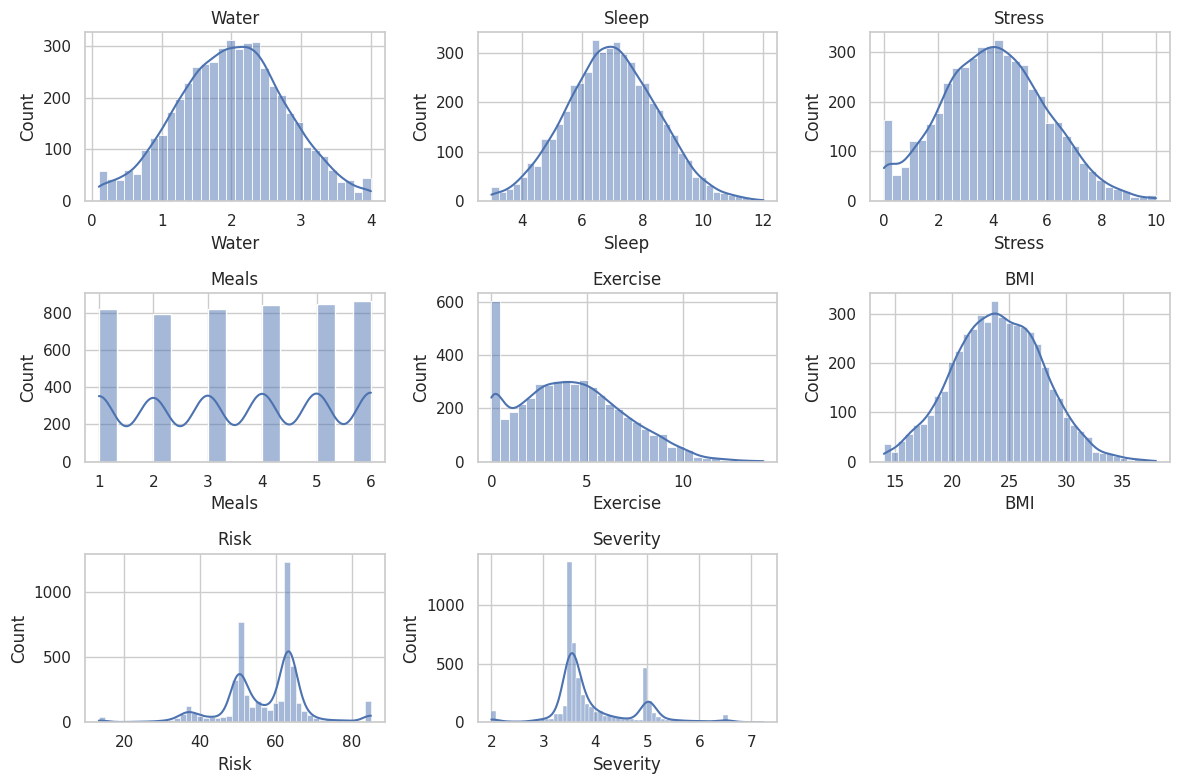

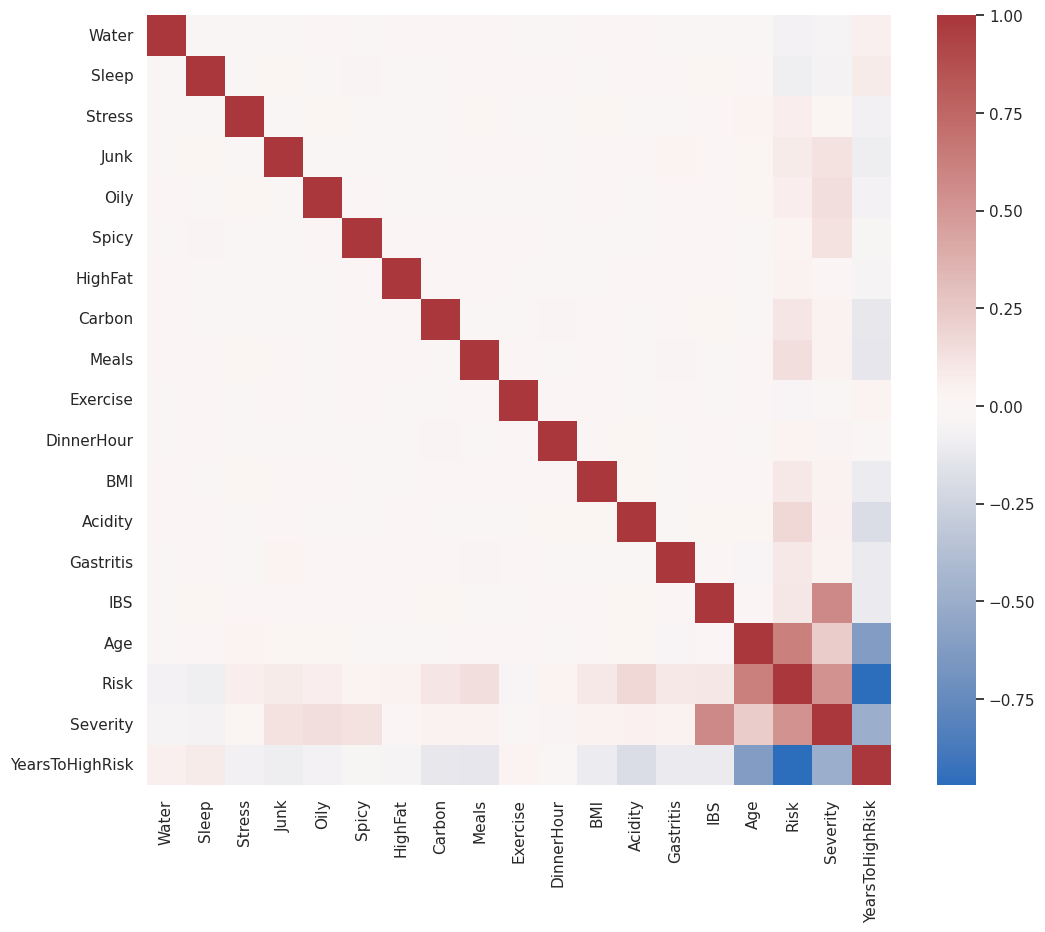

In [ ]:
# ============================================================
# BLOCK 7 — EDA PLOTS (HISTOGRAMS + HEATMAP)
# ============================================================

plt.figure(figsize=(12,8))
cols = ['Water','Sleep','Stress','Meals','Exercise','BMI','Risk','Severity']
for i, col in enumerate(cols,1):
    plt.subplot(3,3,i)
    sns.histplot(synthetic_labeled[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/histograms_grid.png")
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(synthetic_labeled.corr(), cmap="vlag", center=0)
plt.savefig(f"{PLOTS_DIR}/correlation_heatmap.png")
plt.show()


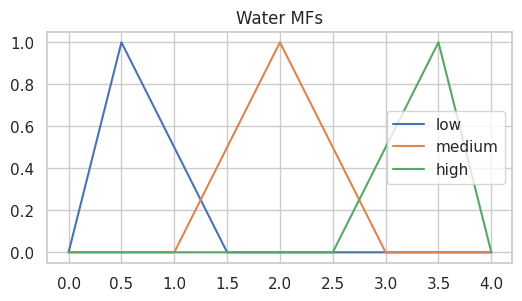

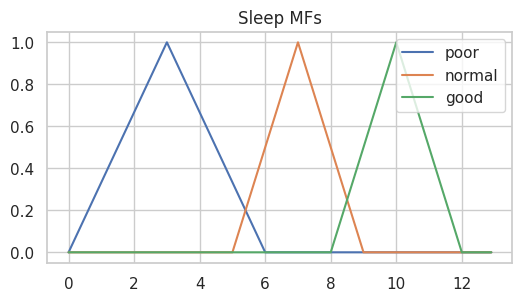

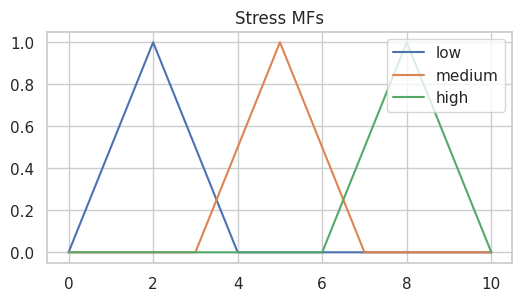

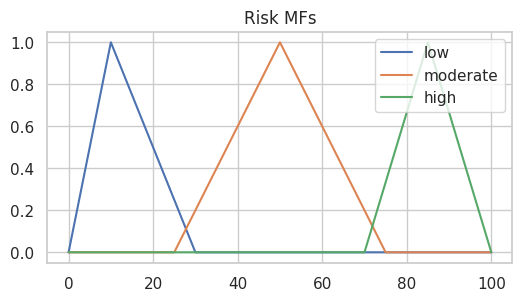

In [ ]:
# ============================================================
# BLOCK 8 — MEMBERSHIP FUNCTION PLOTS
# ============================================================

def plot_mfs(var, name):
    plt.figure(figsize=(6,3))
    for term in var.terms:
        plt.plot(var.universe, var[term].mf, label=term)
    plt.legend()
    plt.title(var.label + " MFs")
    plt.savefig(f"{PLOTS_DIR}/{name}.png")
    plt.show()

plot_mfs(loaded.Water, "mf_water")
plot_mfs(loaded.Sleep, "mf_sleep")
plot_mfs(loaded.Stress, "mf_stress")
plot_mfs(loaded.Risk, "mf_risk")


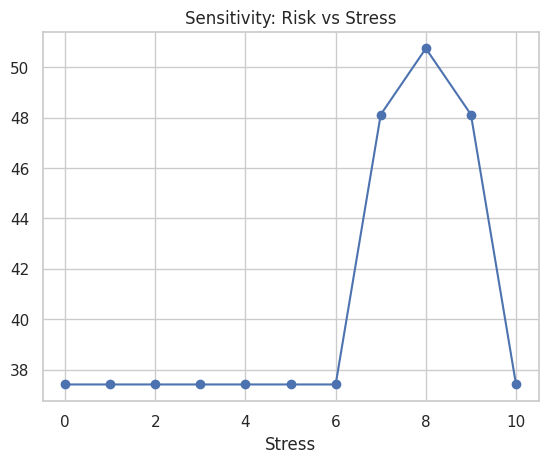

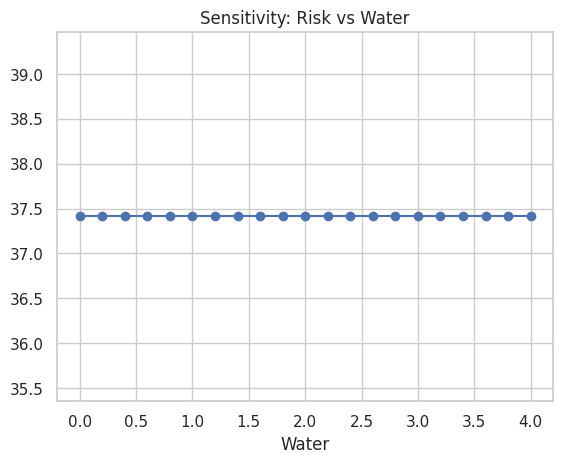

In [ ]:
def sensitivity(fis, base, var, sweep):
    rows = []
    for v in sweep:
        inp = base.copy()
        inp[var] = v
        out = fis.predict(inp)
        rows.append((v, out['Risk'], out['Severity']))
    return pd.DataFrame(rows, columns=[var,'Risk','Severity'])

baseline = {'Water':2.0,'Sleep':7.0,'Stress':3.0,'Junk':0,'Oily':0,'Spicy':0,'HighFat':0,
            'Carbon':0,'Meals':3,'Exercise':3,'DinnerHour':19,'BMI':24,'Acidity':0,'Gastritis':0,'IBS':0}

sweep_stress = np.arange(0,11,1)
sens_stress = sensitivity(loaded, baseline, 'Stress', sweep_stress)
sens_stress.plot(x='Stress', y='Risk', marker='o', title='Sensitivity: Risk vs Stress', legend=False)
plt.show()
plt.savefig(os.path.join(PLOTS_DIR, "sensitivity_stress.png"), dpi=150)
plt.close()

sweep_water = np.linspace(0,4,21)
sens_water = sensitivity(loaded, baseline, 'Water', sweep_water)
sens_water.plot(x='Water', y='Risk', marker='o', title='Sensitivity: Risk vs Water', legend=False)
plt.show()
plt.savefig(os.path.join(PLOTS_DIR, "sensitivity_water.png"), dpi=150)
plt.close()


Robust fuzzy model saved to artifacts/robust_fuzzy_research_model.pkl

Generated and labeled 5000 synthetic samples -> artifacts/synthetic_fuzzy_dataset.csv

Any NaNs in Risk or Severity columns?: False

📘 Dataset Sample (First 5 Rows):


,Water,Sleep,Stress,Junk,Oily,Spicy,HighFat,Carbon,Meals,Exercise,DinnerHour,BMI,Acidity,Gastritis,IBS,Age,Risk,Severity,YearsToHighRisk
0,2.397371,6.364360,2.643011,0,0,0,0,0,2,4.100600,23,24.763950,0,0,0,61,60.361338,3.450984,8.0
1,1.889389,6.319879,3.389001,0,0,1,0,1,1,4.843322,22,28.078702,0,0,0,41,50.000000,3.592053,16.7
2,2.518151,4.306535,2.805238,1,0,0,0,1,6,2.032722,21,16.223053,0,0,0,29,53.705962,3.681007,13.6
3,3.218424,6.504865,4.220836,0,1,0,1,0,6,5.938060,19,25.462870,0,0,0,19,35.859876,2.000000,28.5
4,1.812677,8.099244,6.394357,1,0,1,0,2,6,8.903189,22,23.219245,0,0,0,78,66.121349,3.769819,3.2



Summary saved.
MF plots saved to artifacts/plots

📊 RandomForest Performance Table:



,Metric,Risk Model,Severity Model
0,MAE,0.093274,0.087896
1,R² Score,0.996365,0.949099



🔍 Top 12 Feature Importances (Risk):



,Feature,Importance
0,YearsToHighRisk,0.986592
1,Sleep,0.011564
2,Age,0.001193
3,Water,0.000334
4,Exercise,0.000062
5,DinnerHour,0.000050
6,Stress,0.000043
7,BMI,0.000039
8,Junk,0.000038
9,Meals,0.000034


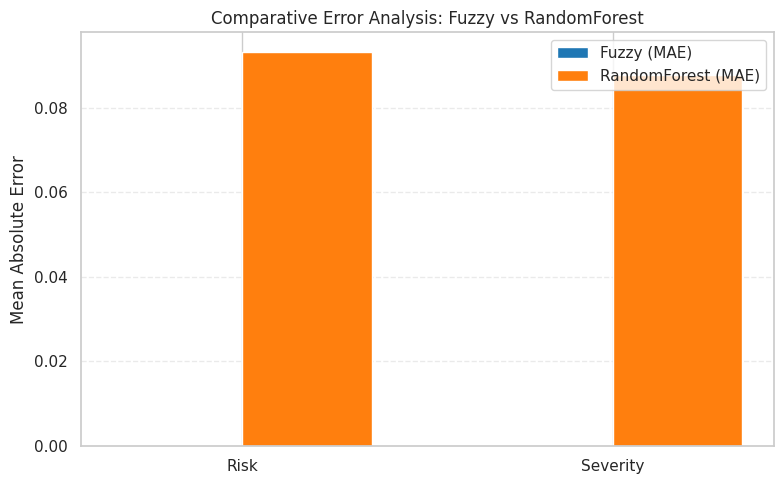

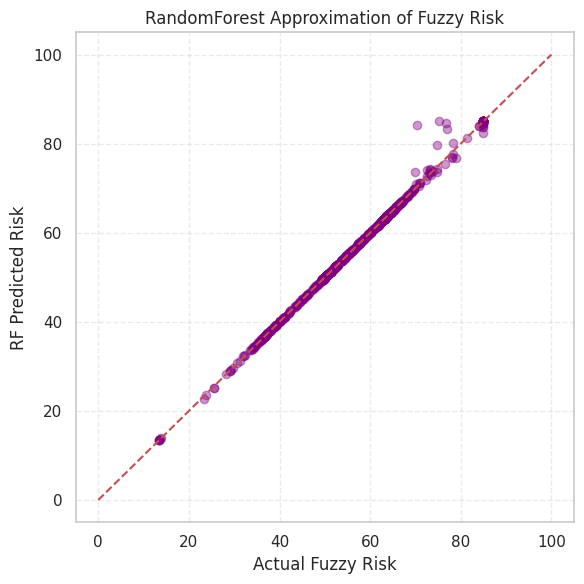

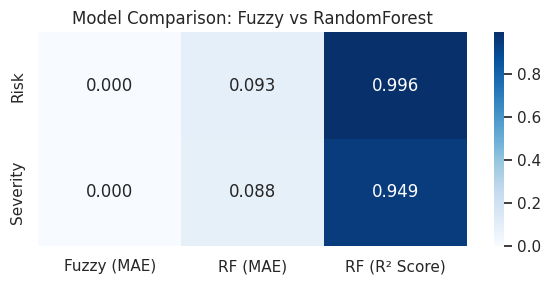


All artifacts saved to folder: artifacts
Plots in: artifacts/plots

FULL PIPELINE EXECUTED SUCCESSFULLY ✔️


In [ ]:
# ============================================================
# 🔟 FINAL EXECUTION BLOCK — FULL PIPELINE + TABLES + PLOTS
# ============================================================

# ---------- MODEL SAVED ----------
print(f"Robust fuzzy model saved to {MODEL_PATH}")

# ---------- GENERATE + LABEL SYNTHETIC DATA ----------
synthetic = generate_synthetic(5000)
synthetic_labeled = label_with_model(synthetic, loaded)

CSV_PATH = os.path.join(ARTIFACT_DIR, "synthetic_fuzzy_dataset.csv")
synthetic_labeled.to_csv(CSV_PATH, index=False)

print(f"\nGenerated and labeled {len(synthetic_labeled)} synthetic samples -> {CSV_PATH}")

print("\nAny NaNs in Risk or Severity columns?:",
      synthetic_labeled[['Risk','Severity']].isna().any().any())


# ============================================================
# 📘 TABLE 1 — DATASET SAMPLE (HEAD)
# ============================================================
print("\n📘 Dataset Sample (First 5 Rows):")
display(synthetic_labeled.head())


# ============================================================
# SUMMARY INFO
# ============================================================
print("\nSummary saved.")
print("MF plots saved to", PLOTS_DIR)


# ============================================================
#  ML MODEL: RANDOM FOREST (Comparative Model)
# ============================================================
X = synthetic_labeled.drop(columns=['Risk','Severity']).astype(float)
y_risk = synthetic_labeled['Risk'].astype(float)
y_sev  = synthetic_labeled['Severity'].astype(float)

# ----- Train/Test Split -----
X_train, X_test, y_train, y_test = train_test_split(X, y_risk, test_size=0.2, random_state=42)
rf_risk = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_risk.fit(X_train, y_train)
pred_r = rf_risk.predict(X_test)

mae_r = mean_absolute_error(y_test, pred_r)
r2_r = r2_score(y_test, pred_r)

# ----- Severity Model -----
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_sev, test_size=0.2, random_state=42)
rf_sev = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_sev.fit(X_train_s, y_train_s)
pred_s = rf_sev.predict(X_test_s)

mae_s = mean_absolute_error(y_test_s, pred_s)
r2_s = r2_score(y_test_s, pred_s)


# ============================================================
# 📊 TABLE 2 — RANDOMFOREST PERFORMANCE (RISK & SEVERITY)
# ============================================================
performance_df = pd.DataFrame({
    "Metric": ["MAE", "R² Score"],
    "Risk Model": [mae_r, r2_r],
    "Severity Model": [mae_s, r2_s]
})

print("\n📊 RandomForest Performance Table:\n")
display(performance_df)


# ============================================================
# 🔍 TABLE 3 — FEATURE IMPORTANCE TABLE
# ============================================================
feat_imp = pd.Series(rf_risk.feature_importances_, index=X.columns).sort_values(ascending=False)
features_df = feat_imp.head(12).reset_index()
features_df.columns = ["Feature", "Importance"]

print("\n🔍 Top 12 Feature Importances (Risk):\n")
display(features_df)


# ============================================================
#  📈 COMPARATIVE ANALYSIS PLOTS (Fuzzy vs ML)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------- 1. BAR CHART (Fuzzy vs RandomForest Errors) ----------
plt.figure(figsize=(8,5))
labels = ['Risk', 'Severity']
fuzzy_errors = [0, 0]   # rule-based fuzzy has no training error
ml_errors = [mae_r, mae_s]

x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, fuzzy_errors, width, label='Fuzzy (MAE)', color='#1f77b4')
plt.bar(x + width/2, ml_errors, width, label='RandomForest (MAE)', color='#ff7f0e')

plt.ylabel("Mean Absolute Error")
plt.title("Comparative Error Analysis: Fuzzy vs RandomForest")
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/comparison_bar_chart.png", dpi=150)
plt.show()


# ---------- 2. SCATTER PLOT (Predicted vs Actual Risk) ----------
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_r, alpha=0.4, color='purple')
plt.plot([0,100], [0,100], 'r--')

plt.xlabel("Actual Fuzzy Risk")
plt.ylabel("RF Predicted Risk")
plt.title("RandomForest Approximation of Fuzzy Risk")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/rf_pred_vs_actual.png", dpi=150)
plt.show()


# ---------- 3. HEATMAP TABLE (Fuzzy vs ML Metrics) ----------
comp_df = pd.DataFrame({
    "Fuzzy (MAE)": [0, 0],
    "RF (MAE)": [mae_r, mae_s],
    "RF (R² Score)": [r2_r, r2_s]
}, index=["Risk", "Severity"])

plt.figure(figsize=(6,3))
sns.heatmap(comp_df, annot=True, cmap="Blues", fmt=".3f")
plt.title("Model Comparison: Fuzzy vs RandomForest")
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/comparison_heatmap.png", dpi=150)
plt.show()


# ============================================================
# FINAL SUMMARY
# ============================================================
print("\nAll artifacts saved to folder:", ARTIFACT_DIR)
print("Plots in:", PLOTS_DIR)
print("\nFULL PIPELINE EXECUTED SUCCESSFULLY ✔️")


In [ ]:
# ============================================================
# BLOCK 11 — SAVE SUMMARY
# ============================================================

with open(os.path.join(ARTIFACT_DIR,"project_summary.txt"),"w") as f:
    f.write("Project Summary...")

In [ ]:
compare_df = synthetic_labeled.sample(200, random_state=42)

fuzzy_r = []
fuzzy_s = []
ml_r = []
ml_s = []

for i, row in compare_df.iterrows():

    # Keep all training inputs (including YearsToHighRisk)
    inp = row.drop(["Risk", "Severity"]).to_dict()

    # Fuzzy prediction
    out_fuzzy = loaded.predict(inp)
    fuzzy_r.append(out_fuzzy["Risk"])
    fuzzy_s.append(out_fuzzy["Severity"])

    # ML prediction WITHOUT warnings (use DataFrame)
    ml_input_df = pd.DataFrame([inp])
    ml_r.append(rf_risk.predict(ml_input_df)[0])
    ml_s.append(rf_sev.predict(ml_input_df)[0])

compare_results = pd.DataFrame({
    "Fuzzy_Risk": fuzzy_r,
    "ML_Risk": ml_r,
    "Fuzzy_Severity": fuzzy_s,
    "ML_Severity": ml_s
})

compare_results.to_csv(os.path.join(ARTIFACT_DIR, "fuzzy_vs_ml_comparison.csv"), index=False)

print(compare_results.head())
print("Saved fuzzy_vs_ml_comparison.csv")


   Fuzzy_Risk    ML_Risk  Fuzzy_Severity  ML_Severity
0   63.054081  63.054081        4.569467     4.559543
1   53.919717  53.916522        4.180555     3.931723
2   64.229083  64.222632        3.605232     3.600274
3   63.054081  63.047989        5.000000     5.006216
4   39.339401  39.289532        3.073820     3.248779
Saved fuzzy_vs_ml_comparison.csv


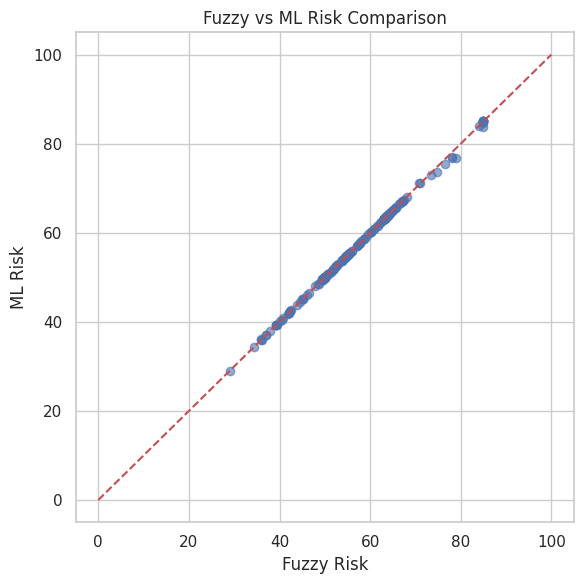

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(compare_results["Fuzzy_Risk"], compare_results["ML_Risk"], alpha=0.6)
plt.plot([0,100],[0,100], 'r--')
plt.xlabel("Fuzzy Risk")
plt.ylabel("ML Risk")
plt.title("Fuzzy vs ML Risk Comparison")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "comparison_risk_scatter.png"), dpi=140)
plt.show()


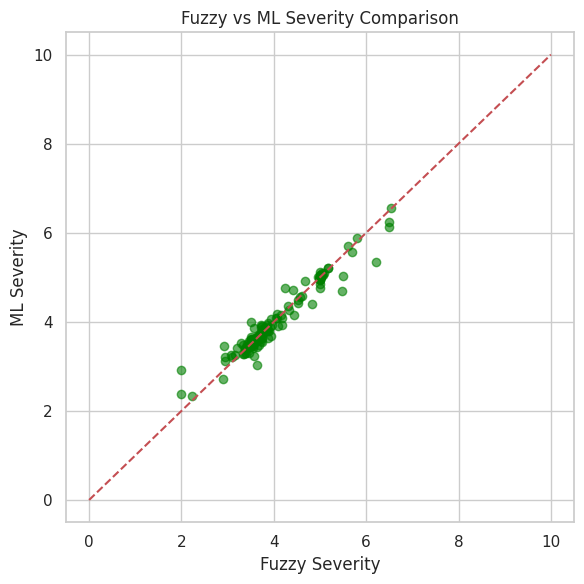

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(compare_results["Fuzzy_Severity"], compare_results["ML_Severity"], alpha=0.6, color='green')
plt.plot([0,10],[0,10], 'r--')
plt.xlabel("Fuzzy Severity")
plt.ylabel("ML Severity")
plt.title("Fuzzy vs ML Severity Comparison")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "comparison_severity_scatter.png"), dpi=140)
plt.show()


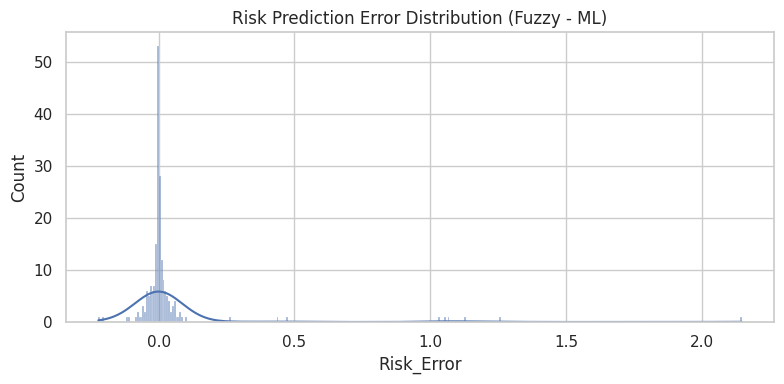

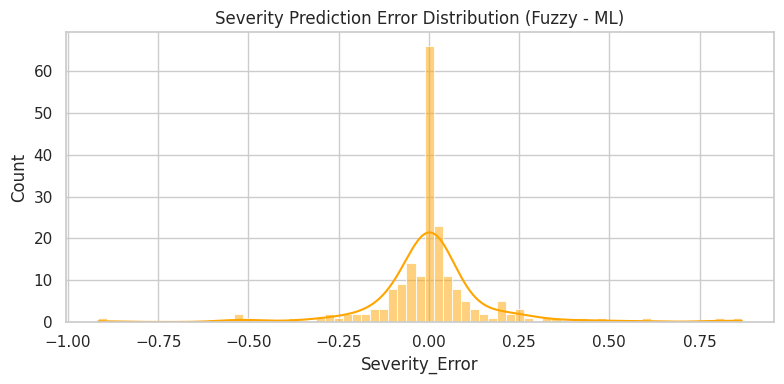

In [ ]:
compare_results["Risk_Error"] = compare_results["Fuzzy_Risk"] - compare_results["ML_Risk"]
compare_results["Severity_Error"] = compare_results["Fuzzy_Severity"] - compare_results["ML_Severity"]

plt.figure(figsize=(8,4))
sns.histplot(compare_results["Risk_Error"], kde=True)
plt.title("Risk Prediction Error Distribution (Fuzzy - ML)")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "risk_error_hist.png"), dpi=140)
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(compare_results["Severity_Error"], kde=True, color='orange')
plt.title("Severity Prediction Error Distribution (Fuzzy - ML)")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "severity_error_hist.png"), dpi=140)
plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

r2_risk = r2_score(compare_results["Fuzzy_Risk"], compare_results["ML_Risk"])
r2_sev  = r2_score(compare_results["Fuzzy_Severity"], compare_results["ML_Severity"])

mae_risk = mean_absolute_error(compare_results["Fuzzy_Risk"], compare_results["ML_Risk"])
mae_sev  = mean_absolute_error(compare_results["Fuzzy_Severity"], compare_results["ML_Severity"])

print("\n===== COMPARATIVE ANALYSIS =====")
print(f"Risk R² (Fuzzy vs ML)       : {r2_risk:.4f}")
print(f"Severity R² (Fuzzy vs ML)   : {r2_sev:.4f}")
print(f"Risk MAE (Fuzzy vs ML)      : {mae_risk:.4f}")
print(f"Severity MAE (Fuzzy vs ML)  : {mae_sev:.4f}")
print("================================\n")



===== COMPARATIVE ANALYSIS =====
Risk R² (Fuzzy vs ML)       : 0.9995
Severity R² (Fuzzy vs ML)   : 0.9481
Risk MAE (Fuzzy vs ML)      : 0.0651
Severity MAE (Fuzzy vs ML)  : 0.0899



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, VBox, HBox, HTML, Output, Layout
from IPython.display import display
import skfuzzy as fuzz

# ---------- check model ----------
try:
    loaded
except:
    raise RuntimeError("ERROR: `loaded` fuzzy model not found. Load the model first.")

# ---------- outputs ----------
out_gauge1 = Output()
out_gauge2 = Output()
out_radar  = Output()
out_curve  = Output()
out_text   = Output()
out_explain = Output()
display(HTML("""
<style>
body, .jp-Notebook { background: linear-gradient(135deg,#e8f1ff,#ffffff) !important; }
.form-card, .result-card, .explain-card {
    background: #ffffffec; border:1px solid #c8d7ed; padding:20px;
    border-radius:12px; box-shadow:0 4px 12px rgba(0,0,0,0.06); margin-top:18px;
}
.sub-heading { color:#0a2a63 !important; font-weight:800 !important; font-size:18px !important; }
.widget-label, label { color:#0d2a4d !important; font-weight:700 !important; font-size:15px !important; }
input, select { background:#fff !important; color:#0d2a4d !important; border:2px solid #7aa6d9 !important; border-radius:8px !important; padding:6px !important; font-weight:600 !important; }
.result-title { color:#0a2a63 !important; font-weight:800 !important; font-size:22px !important; }
.recom-title { color:#0a2a63 !important; font-weight:800 !important; font-size:20px !important; margin-top:12px; }
.recom-content { color:#0d2a4d !important; font-size:16px !important; font-weight:500 !important; }
.rule-title { color:#0a2a63; font-weight:700; font-size:16px; margin-bottom:6px; }
.rule-row { font-family: monospace; color:#0c2b4a; }
.firing { color:#0c2b4a; font-weight:700; }
</style>
"""))

# ---------- TITLE ----------
display(HTML("<h2 class='result-title'>🩺 Fuzzy Gas Risk Predictor — With Rule Explanation</h2><p class='recom-content'>Explainable fuzzy outputs & short prevention plan.</p><hr>"))

Age        = widgets.IntText(description="Age (years)", value=25)
Water      = widgets.FloatText(description="Water Intake (L/day)", value=2.0)
Sleep      = widgets.FloatText(description="Sleep Duration (hrs)", value=7.0)
Stress     = widgets.Dropdown(description="Stress Level", options=[("Low",1),("Medium",2),("High",3)], value=2)

Junk       = widgets.Dropdown(description="Junk Food Consumption", options=[("Never",0),("Rarely",1),("Often",2),("Daily",3)], value=0)
Oily       = widgets.Dropdown(description="Oily Foods", options=[("Never",0),("Sometimes",1),("Often",2)], value=0)
Spicy      = widgets.Dropdown(description="Spicy Foods", options=[("Never",0),("Sometimes",1),("Often",2)], value=0)
HighFat    = widgets.Dropdown(description="High-Fat Foods", options=[("Never",0),("Sometimes",1),("Often",2)], value=0)

Carbon     = widgets.Dropdown(description="Carbonated Drinks", options=[("None",0),("Occasionally",1),("Frequently",2)], value=0)
Meals      = widgets.IntText(description="Meals Per Day", value=3)

Exercise   = widgets.FloatText(description="Exercise (hrs/week)", value=3.0)
Dinner     = widgets.Dropdown(description="Dinner Timing", options=[("6 PM",18),("7 PM",19),("8 PM",20),("9 PM",21),("10 PM",22),("11 PM",23)], value=19)

BMI        = widgets.FloatText(description="BMI", value=24.0)
Acidity    = widgets.Dropdown(description="Acidity", options=[("No",0),("Yes",1)], value=0)
Gastritis  = widgets.Dropdown(description="Gastritis", options=[("No",0),("Yes",1)], value=0)
IBS        = widgets.Dropdown(description="IBS", options=[("No",0),("Yes",1)], value=0)

submit_btn = widgets.Button(description="Predict", button_style="success", layout=Layout(width="220px", height="45px"))

def mem_degree(var_obj, term_name, value):
    """Return membership degree of 'value' in var_obj[term_name]."""
    # var_obj[term_name].mf exists; use interpolation on universe
    try:
        return float(fuzz.interp_membership(var_obj.universe, var_obj[term_name].mf, value))
    except Exception:
        return 0.0

rule_specs = [
    ( [("Acidity","yes")], "high", "moderate", "Acidity present → High risk" ),
    ( [("Gastritis","yes")], "high", "moderate", "Gastritis present → High risk" ),
    ( [("IBS","yes")], "high", "severe", "IBS present → High risk & severe" ),

    ( [("Junk","yes"), ("Oily","yes")], "high", "moderate", "Junk + Oily → High risk" ),
    ( [("Spicy","yes"), ("HighFat","yes")], "high", "moderate", "Spicy + High-fat → High risk" ),
    ( [("Carbon","frequent")], "high", "moderate", "Frequent carbonated drinks → High risk" ),

    ( [("Sleep","poor"), ("Stress","high")], "high", "moderate", "Poor sleep + High stress → High risk" ),
    ( [("DinnerHour","late"), ("Meals","high")], "high", "moderate", "Late dinner + Many meals → High risk" ),

    ( [("BMI","obese"), ("Exercise","low")], "high", "moderate", "Obese + Low exercise → High risk" ),
    ( [("BMI","normal"), ("Exercise","high")], "low", "mild", "Normal BMI + High exercise → Low risk" ),

    ( [("Water","high"), ("Sleep","good")], "low", "mild", "High water + Good sleep → Low risk" ),

    ( [("Water","medium"), ("Sleep","normal")], "moderate", "moderate", "Moderate water + Normal sleep → Moderate risk" ),
    ( [("Meals","medium")], "moderate", "moderate", "Moderate meals → Moderate risk" ),

    ( [("Spicy","yes"), ("Carbon","occasional")], "moderate", "moderate", "Spicy + occasional carbon -> Moderate" ),
    ( [("Junk","yes"), ("Sleep","poor")], "high", "moderate", "Junk + Poor sleep → High risk" ),
    ( [("Water","low"), ("Junk","yes")], "high", "moderate", "Low water + Junk → High risk" ),

    ( [("Stress","high")], "high", "moderate", "High stress → High risk" ),
    ( [("Sleep","normal")], "moderate", "mild", "Normal sleep → Moderate/mild" ),

    ( [("Water","high"), ("Exercise","high")], "low", "mild", "High water + High exercise → Low risk" ),
    ( [("Meals","low"), ("BMI","normal")], "low", "mild", "Few meals + Normal BMI → Low risk" ),
    ( [("DinnerHour","early"), ("Sleep","good")], "low", "mild", "Early dinner + Good sleep → Low risk" ),

    ( [("Meals","high"), ("Oily","yes")], "high", "moderate", "Many meals + Oily → High risk" ),
    ( [("Meals","low"), ("Stress","high")], "moderate", "moderate", "Few meals + High stress → Moderate risk" ),

    ( [("Carbon","frequent"), ("Sleep","poor")], "high", "moderate", "Frequent carbon + Poor sleep → High risk" ),
    ( [("Junk","yes"), ("Oily","yes"), ("Spicy","yes")], "high", "severe", "Junk+Oily+Spicy → High & severe" ),
]

def compute_rule_firing(inp):
    """
    For each rule_spec, compute membership degrees and firing strength.
    Returns list of (description, firing_strength, rule_spec).
    """
    results = []
    # get var objects from loaded
    for spec in rule_specs:
        antecedents, rterm, sterm, desc = spec
        degrees = []
        skip_spec=False
        for varname, term in antecedents:
            try:
                var_obj = getattr(loaded, varname)
            except AttributeError:
                # if variable not found, try alternate mapping
                skip_spec=True
                break

            # If term like 'yes'/'no' is used but model stored 'yes'/'no' that's fine.
            deg = mem_degree(var_obj, term, inp.get(varname, 0))
            degrees.append(deg)
        if skip_spec:
            continue
        if len(degrees)==0:
            firing = 0.0
        else:
            firing = float(np.min(degrees))  # AND = min
        results.append((desc, firing, spec))
    # sort by firing desc
    results_sorted = sorted(results, key=lambda x: x[1], reverse=True)
    return results_sorted

def generate_prevention_tips(inp, top_rules):
    tips = []
    # lifestyle tips
    if inp.get("Water",0) < 2.0:
        tips.append("Increase daily water intake to 2–3 L to improve digestion.")
    if inp.get("Sleep",0) < 6.5:
        tips.append("Improve sleep duration to 7–8 hrs; poor sleep increases gut sensitivity.")
    # stress
    stress_val = inp.get("Stress",2)
    if stress_val==3:
        tips.append("Address stress via relaxation, mindfulness, or exercise; high stress raises gas risk.")
    # diet
    if inp.get("Junk",0) >= 2 or inp.get("Oily",0) >= 1 or inp.get("Spicy",0) >= 1 or inp.get("HighFat",0) >= 1:
        tips.append("Reduce junk/oily/spicy/high-fat food; prefer home-cooked, fiber-rich meals.")
    # carbonated drinks
    if inp.get("Carbon",0) == 2:
        tips.append("Cut down carbonated drinks; frequent soda intake contributes to gas.")
    # exercise
    if inp.get("Exercise",0) < 2:
        tips.append("Increase regular physical activity to at least 3 hrs/week for gut motility.")
    # BMI
    if inp.get("BMI",24) >= 30:
        tips.append("Consider weight management (diet + exercise); obesity correlates with gas risk.")
    # dinner timing
    if inp.get("DinnerHour",19) >= 22:
        tips.append("Avoid very late dinners; aim to finish meals 2–3 hrs before sleep.")
    # if no tips so far
    if len(tips)==0:
        tips.append("Maintain current healthy lifestyle; regular checkups are recommended.")
    # also add top rule-based tip: if top rule severe, append
    if len(top_rules)>0:
        top_desc, top_fire, _ = top_rules[0]
        if top_fire>0.35:
            tips.insert(0, f"Key driver: {top_desc} (activation {int(top_fire*100)}%). Address this first.")
    return tips

def gauge_chart(value, title, max_val):
    plt.figure(figsize=(7,1.2))
    color = "green" if value < max_val*0.35 else "orange" if value < max_val*0.7 else "red"
    plt.barh([0], [value], color=color)
    plt.xlim(0, max_val)
    plt.yticks([])
    plt.title(title)
    plt.tight_layout()
    plt.show()

def radar_chart(values, labels):
    angles = np.linspace(0, 2*np.pi, len(values), endpoint=False)
    values = np.concatenate((values, [values[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    plt.figure(figsize=(6.5,6.5))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, linewidth=2, color="#1a73e8")
    ax.fill(angles, values, alpha=0.25, color="#1a73e8")
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=9)
    ax.set_yticklabels([])
    plt.title("Health Profile Radar Chart")
    plt.tight_layout()
    plt.show()

def plot_progression_curve(fis, base_inputs):
    ages = np.arange(base_inputs["Age"], base_inputs["Age"] + 21)
    risks = []
    for a in ages:
        mod_input = base_inputs.copy()
        mod_input["Age"] = int(a)
        risks.append(fis.predict(mod_input)["Risk"])
    plt.figure(figsize=(8,4))
    plt.plot(ages, risks, marker='o', color="#1a73e8")
    plt.title("Projected Gas Risk Progression (Next 20 Years)")
    plt.xlabel("Age")
    plt.ylabel("Predicted Gas Risk")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def on_submit_clicked(b):
    out_gauge1.clear_output(); out_gauge2.clear_output(); out_radar.clear_output(); out_curve.clear_output(); out_text.clear_output(); out_explain.clear_output()

    # Build inputs (mirror model names used in loaded)
    inputs = {
        "Age": int(Age.value),
        "Water": float(Water.value), "Sleep": float(Sleep.value),
        "Stress": 2 if Stress.value==1 else (5 if Stress.value==2 else 8),
        "Junk": 1 if Junk.value in (1,2,3) else 0,  # treat any non-never as yes for model terms 'yes'/'no'
        "Oily": 1 if Oily.value in (1,2) else 0,
        "Spicy": 1 if Spicy.value in (1,2) else 0,
        "HighFat": 1 if HighFat.value in (1,2) else 0,
        "Carbon": int(Carbon.value),
        "Meals": int(Meals.value),
        "Exercise": float(Exercise.value),
        "DinnerHour": int(Dinner.value),
        "BMI": float(BMI.value),
        "Acidity": int(Acidity.value),
        "Gastritis": int(Gastritis.value),
        "IBS": int(IBS.value)
    }

    # predict using fuzzy model
    out = loaded.predict(inputs)
    risk = round(out['Risk'],2); sev = round(out['Severity'],2); yhr = out.get('YearsToHighRisk', None)
    risk_label = "🟢 Low" if risk < 35 else "🟡 Moderate" if risk < 70 else "🔴 High"
    sev_label  = "🟢 Mild" if sev < 3 else "🟡 Moderate" if sev < 7 else "🔴 Severe"

    # Gauges and radar
    with out_gauge1: gauge_chart(risk, "Gas Risk Gauge", 100)
    with out_gauge2: gauge_chart(sev, "Severity Gauge", 10)
    with out_radar:
        radar_vals = np.array([
            inputs["Water"]/4, inputs["Sleep"]/12, inputs["Stress"]/10, inputs["Age"]/90,
            (0 if inputs["Junk"]==0 else 1), inputs["Oily"], inputs["Spicy"], inputs["HighFat"],
            inputs["Carbon"]/2, inputs["Meals"]/6, inputs["Exercise"]/20,
            (inputs["DinnerHour"]-16)/8, (inputs["BMI"]-12)/33,
            inputs["Acidity"], inputs["Gastritis"], inputs["IBS"]
        ])
        radar_labels = ["Water","Sleep","Stress","Age","Junk","Oily","Spicy","HighFat","Carbon","Meals","Exercise","DinnerHr","BMI","Acidity","Gastritis","IBS"]
        radar_chart(radar_vals, radar_labels)

    # progression curve
    with out_curve:
        plot_progression_curve(loaded, inputs)

    # textual results + recommendations
    with out_text:
        display(HTML(f"""
            <div class='result-title'>Gas Risk Results</div>
            <div class='recom-content'>
                <b>Gas Risk:</b> {risk}/100 &nbsp;&nbsp; {risk_label}<br>
                <b>Severity:</b> {sev}/10 &nbsp;&nbsp; {sev_label}<br>
                <b>Years Before High Risk:</b> {yhr} years
            </div>
            <hr>
            <div class='recom-title'>Recommendations</div>
        """))
        # generate tips below
        top_rules = compute_rule_firing(inputs)
        tips = generate_prevention_tips(inputs, top_rules)
        for t in tips:
            display(HTML(f"<p class='recom-content'>• {t}</p>"))

    # explanation panel: show top N rules with firing strength
    with out_explain:
        display(HTML("<div class='rule-title'> Top Activated Fuzzy Rules (why model predicted this)</div>"))
        topN = [r for r in top_rules if r[1]>0.01][:8]  # filter tiny activations
        if len(topN)==0:
            display(HTML("<p class='recom-content'>No strong rules activated — prediction relies on general tendencies (fallback centroids).</p>"))
        else:
            for desc, fire, spec in topN:
                pct = int(fire*100)
                display(HTML(f"<div class='rule-row'>• <b>{desc}</b> — Activation: <span class='firing'>{pct}%</span></div>"))

submit_btn.on_click(on_submit_clicked)

left_col = VBox([ HTML("<div class='sub-heading'>Personal Details</div>"), Age, Water, Sleep, Stress,
                  HTML("<br><div class='sub-heading'>Dietary Intake</div>"), Junk, Oily, Spicy, HighFat, Carbon, Meals ])

right_col = VBox([ HTML("<div class='sub-heading'>Lifestyle</div>"), Exercise, Dinner,
                   HTML("<br><div class='sub-heading'>Body & Medical Conditions</div>"), BMI, Acidity, Gastritis, IBS ])

form_card = VBox([ HBox([left_col, HTML("&nbsp;&nbsp;&nbsp;&nbsp;"), right_col]), HTML("<br>"), submit_btn ])
form_card.add_class("form-card")

# results area: visual outputs + explanation stacked
results_visuals = VBox([ out_gauge1, HTML("<br>"), out_gauge2, HTML("<br>"), out_radar, HTML("<br>"), out_curve ])
results_visuals.add_class("result-card")

explain_box = VBox([ out_text, HTML("<hr>"), out_explain ])
explain_box.add_class("explain-card")

display(HBox([ form_card, HTML("&nbsp;&nbsp;&nbsp;&nbsp;"), VBox([results_visuals, explain_box]) ]))


HTML(value='\n<style>\nbody, .jp-Notebook { background: linear-gradient(135deg,#e8f1ff,#ffffff) !important; }\…

HTML(value="<h2 class='result-title'>🩺 Fuzzy Gas Risk Predictor — With Rule Explanation</h2><p class='recom-co…